# Importing libraries

In [1]:
import os
import sys
import json
from scipy import *
import numpy as np
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import pymc3 as pm
from pymc3 import floatX
import theano
import theano.tensor as tt
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

import seaborn as sn
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score
)

from sklearn.metrics import (
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10 


import time
from datetime import datetime
import calendar

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\49177\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Importing data

In [2]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')

In [3]:
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

# Combinig the datasets

In [4]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

df=df.fillna(0)
df['Temperature'] = (df['Temperature']- 32) * 5./9.

types_encoded, types =df['Type'].factorize()
df['Type'] = types_encoded

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315
1,1,1,2010-12-02,46039.49,True,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315
2,1,1,2010-02-19,41595.55,False,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,151315
3,1,1,2010-02-26,19403.54,False,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,151315
4,1,1,2010-05-03,21827.90,False,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,151315


# Feature engineering

In [5]:
data_date = features.groupby("Date").agg({"Temperature":"mean"
                                            ,"Fuel_Price":"mean"
                                            ,"IsHoliday":"sum"
                                            ,"CPI":"mean"
                                           ,"Unemployment":"mean"})
data_date = data_date.sort_index()
temp_date_data = data_date[:'2012-12-10']

data_sales_date = sales.groupby("Date").agg({"Weekly_Sales":"sum"})
data_sales_date.sort_index(inplace=True)
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales/1000000
data_sales_date.Weekly_Sales = data_sales_date.Weekly_Sales.apply(int)
data = pd.merge(data_sales_date, temp_date_data, left_index=True,right_index=True, how='left')
data["IsHoliday"] = data["IsHoliday"].apply(lambda x: 1 if x == 45.0 else 0 )

In [6]:
df_store_ = data
df_store_['year'] = pd.DatetimeIndex(df_store_.index).year

In [7]:
df_store_

,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment,year
Date,,,,,,,
2010-01-10,42,69.868000,2.734333,0,168.354706,8.475289,2010
2010-02-04,50,53.120889,2.827333,0,167.789036,8.497711,2010
2010-02-07,48,77.133333,2.793511,0,167.982101,8.428578,2010
2010-02-19,48,37.719778,2.672067,0,167.871686,8.619311,2010
2010-02-26,43,39.243556,2.683933,0,167.909657,8.619311,2010
...,...,...,...,...,...,...,...
2012-10-08,47,81.580222,3.632911,0,175.689620,7.237333,2012
2012-10-19,45,60.705333,3.880000,0,176.652613,6.953711,2012
2012-10-26,45,61.051111,3.791489,0,176.649482,6.953711,2012


# Bayesian Model Implementation

In [8]:
import pymc3 as pm
from sklearn import preprocessing
indiv_traces = {}
indiv_traces_post = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
year_idx = le.fit_transform(df_store_['year'])
year = le.classes_
n_year = len(year)

for p in year:
    m = pm.Model()



    with m:
          
        data = df_store_[df_store_['year']==p]['Weekly_Sales'].values
        
        alpha = 1.0 / data.mean()
        n = len(data)
    

    
        #prior distributions
    
        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)
        lambda_3 = pm.Exponential("lambda_3", alpha)
        lambda_4 = pm.Exponential("lambda_4", alpha)



    
        tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n*0.4)
        tau_2 = pm.DiscreteUniform("tau_2", lower=n*0.4, upper=n*0.8)
        tau_3 = pm.DiscreteUniform("tau_3", lower=n*0.8, upper=n)
  




    
        idx = np.arange(n) # Index
    
        lambda_ = pm.math.switch(tau_3 >= idx,pm.math.switch(tau_2 >= idx,\
                pm.math.switch(tau_1 >= idx,lambda_1, lambda_2),lambda_3),lambda_4)
              

    
        prob = pm.Deterministic('lambda', lambda_)

        # Define the likelihood function.
    
        y_obs = pm.Poisson("obs", prob, observed=data)

    
        step = pm.NUTS()
        trace = pm.sample(1000,step, model= m)
        indiv_traces[p] = trace
        indiv_traces_post[p] = pm.sample_posterior_predictive(trace, samples=1000, progressbar=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_4, lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_3]
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 242 seconds.
There were 451 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.255572429350842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9118915451488177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.953602259839605, but should be close to 0.8. Try to increase the number of tuning steps.
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37929853782007605, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 2

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_4, lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_3]
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.706276272899665, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_4, lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_3]
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 254 seconds.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 467 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19719591244609427, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8953291485719036, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Model predicted output against the actual sales

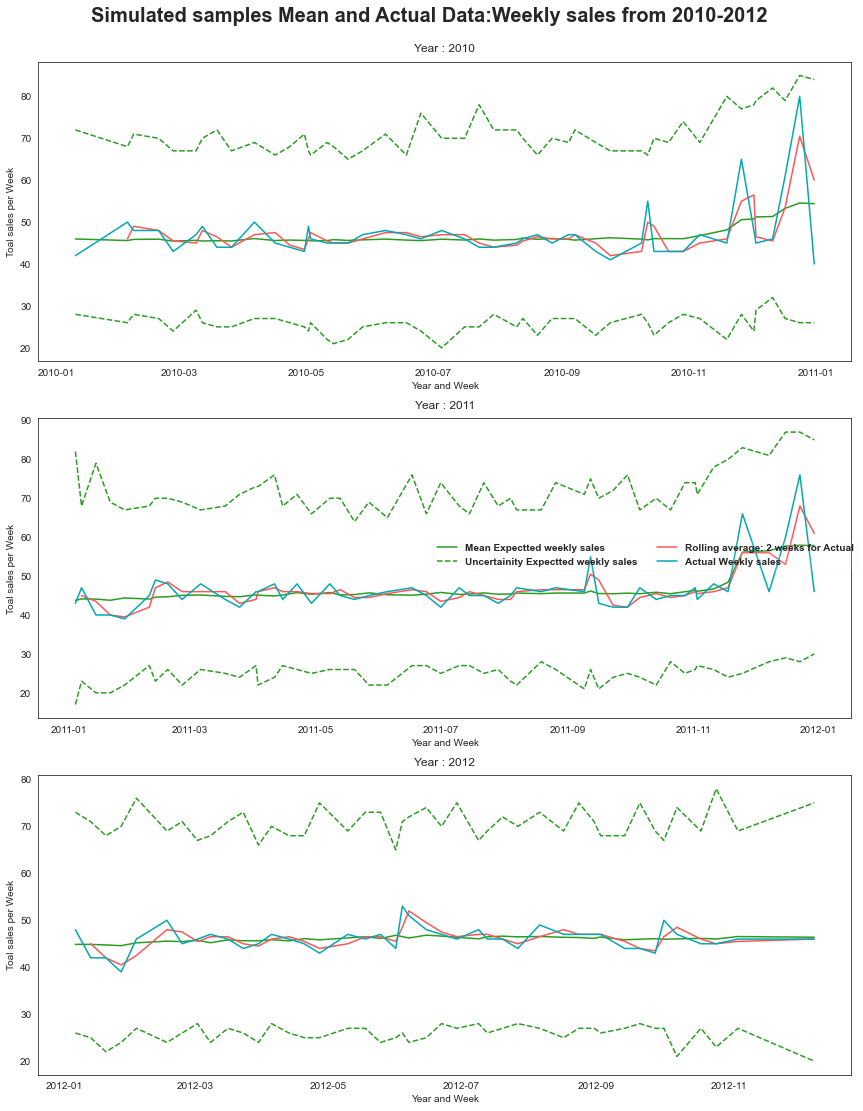

In [9]:
fig, axs = plt.subplots(3,1, figsize=(12, 15))
axs = axs.ravel()
window = 2



for i, j, p in zip([0,1,2], [0,1,2], year):
    
    axs[j].set_ylabel("Toal sales per Week")
    axs[j].set_xlabel('Year and Week')
    
    axs[j].set_title('Year : %s' % p)
    
    axs[j].plot(df_store_[df_store_['year']==p].index,\
                indiv_traces_post[p]['obs'].mean(axis=0), color="#299C21", label='Mean Expectted weekly sales')
    axs[j].plot(df_store_[df_store_['year']==p].index,\
                indiv_traces_post[p]['obs'].max(axis=0),'--', color="#299C21", label='Uncertainity Expectted weekly sales')
    axs[j].plot(df_store_[df_store_['year']==p].index,\
                indiv_traces_post[p]['obs'].min(axis=0),'--', color="#299C21")
    
    
    rolling_mean = df_store_[df_store_['year']==p]['Weekly_Sales'].rolling(window = window, center=False).mean()
    
    axs[j].plot(rolling_mean, color="#FF5555", label="Rolling average: %i weeks for Actual" % window)
    
    axs[j].plot(df_store_[df_store_['year']==p].index,df_store_[df_store_['year']==p]['Weekly_Sales'],\
                color="#00A8B3", label='Actual Weekly sales')

handles, labels = axs[2].get_legend_handles_labels()
legend_properties = {'weight':'bold'}
fig.legend(handles, labels, loc='right',ncol=2,fancybox=True, framealpha=0.1,prop=legend_properties)
fig.suptitle(r'Simulated samples Mean and Actual Data:Weekly sales from 2010-2012',y=1.025,fontsize=20,fontweight='bold')

plt.tight_layout(True);



# ARIMA Model Implementation

In [10]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

In [11]:
df_ac = df_store_[['Weekly_Sales']]

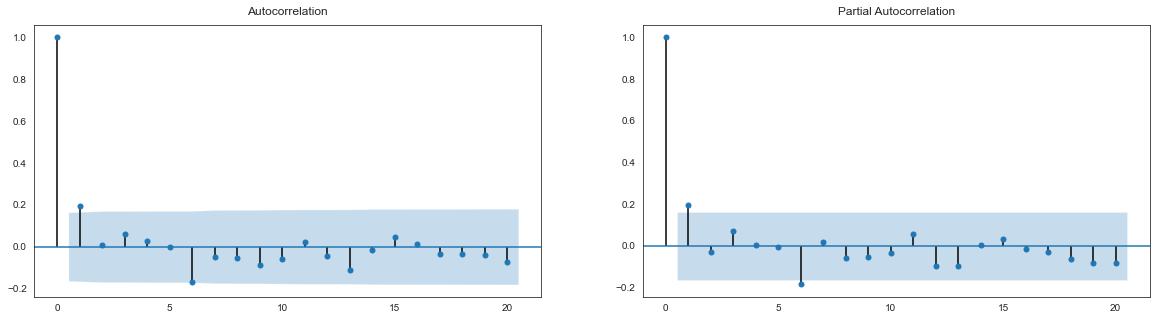

In [12]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(df_ac.values, lags=20, alpha=0.05, ax=axes[0])
plot_pacf(df_ac.values, lags=20, alpha=0.05, ax=axes[1])
plt.show()

In [13]:
from sklearn.linear_model import LinearRegression

def fit_ar_model(ts, orders):
    
    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    mask = ~np.isnan(X[:,:1]).squeeze()
    
    Y= ts.values
    
    lin_reg=LinearRegression()
    
    lin_reg.fit(X[mask],Y[mask])
    
    print(lin_reg.coef_, lin_reg.intercept_)

    print('Score factor: %.2f' % lin_reg.score(X[mask],Y[mask]))
    
    return lin_reg.coef_, lin_reg.intercept_
    
def predict_ar_model(ts, orders, coef, intercept):
    return np.array([np.sum(np.dot(coef, ts.values[(i-orders)].squeeze())) + intercept  if i >= np.max(orders) else np.nan for i in range(len(ts))])

[[ 0.20508343 -0.00429729 -0.03021136]] [38.66873995]
Score factor: 0.04


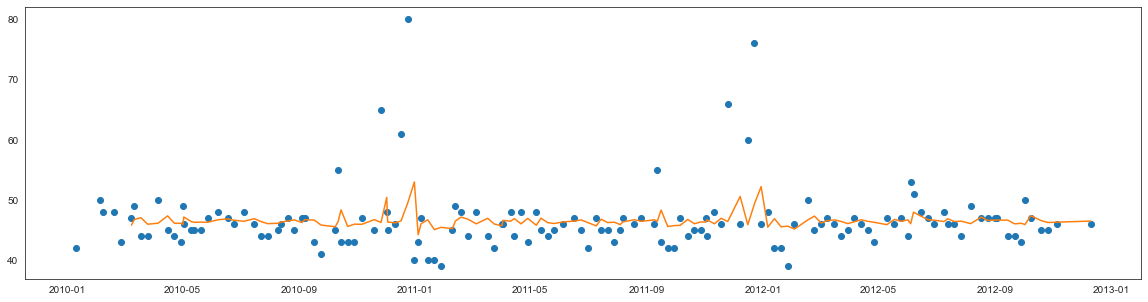

In [14]:
orders=np.array([1,5,2])
coef, intercept = fit_ar_model(df_ac,orders)
pred=pd.DataFrame(index=df_ac.index, data=predict_ar_model(df_ac, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(df_ac, 'o')
plt.plot(pred)
plt.show()

[[ 1.00000000e+00 -1.39630994e-16  9.48112585e-17]] [-4.26325641e-14]
Score factor: 1.00


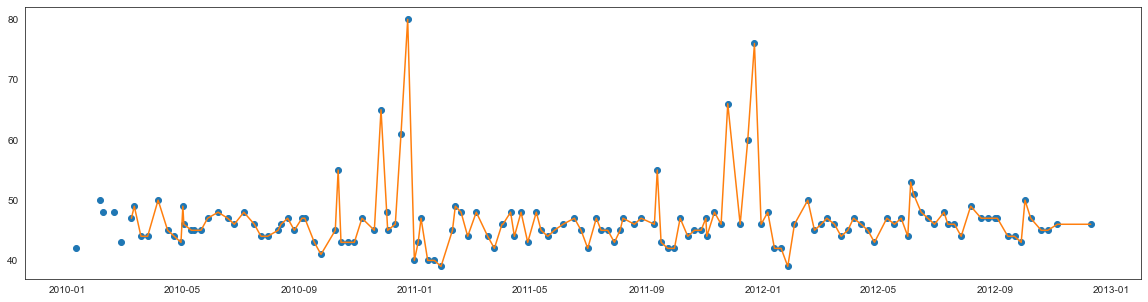

In [15]:
orders=np.array([0,5,2])
coef, intercept = fit_ar_model(df_ac,orders)
pred=pd.DataFrame(index=df_ac.index, data=predict_ar_model(df_ac, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(df_ac, 'o')
plt.plot(pred)
plt.show()